Klassenaufteilung mit Simulated Annealing
- https://github.com/ZhijingEu/Wedding-Seating-Problem-Simulated-Annealing

In [1]:
import numpy as np
import random
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Free seats in Klassen
def count_StufeAnzahl(KinderAnonym, KlassenVektor):
    # KinderAnonym = Kinder_df.Anonym
    # KlassenVektor = [KlasseSignCode[KindKlasse] for KindKlasse in Kinder_df.Klasse]
    KlassenZahl = np.unique(KlassenVektor).shape[0]
    StufeAnzahl = np.zeros((3, KlassenZahl))
    for indx, Kind in enumerate(KinderAnonym):
        StufeKind = int(Kind.split(':')[3])-1
        StufeAnzahl[StufeKind, KlassenVektor[indx]] += 1
    return StufeAnzahl

def check_StufeAnzahl(KinderAnonym, KlassenVektor):
    '''Check whether the age distribution in the classes is balanced
    True: balanced
    False: unbalanced
    '''
    StufeAnzahl = count_StufeAnzahl(KinderAnonym, KlassenVektor)
    return not any([max(Stufe) > 8 or min(Stufe) < 4 for Stufe in StufeAnzahl])

def generate_ClassRandBalanced(KinderZahl, KlassenZahl):
    FreeSeats = int(np.ceil(KinderZahl/KlassenZahl))
    FreeSeats_vec = np.ravel([list([Class])*FreeSeats for Class in range(KlassenZahl)])
    KlassenVektor = list()
    for Kind in range(KinderZahl):
        ClassSelect = np.random.randint(len(FreeSeats_vec))
        KlassenVektor.append(FreeSeats_vec[ClassSelect])
        FreeSeats_vec = np.delete(FreeSeats_vec, ClassSelect)
    return KlassenVektor

def count_SexDist(KinderAnonym, KlassenVektor):
    # KinderAnonym = Kinder_df.Anonym
    # KlassenVektor = [KlasseSignCode[KindKlasse] for KindKlasse in Kinder_df.Klasse]
    KlassenZahl = np.unique(KlassenVektor).shape[0]
    SexCount = np.zeros((2, KlassenZahl))
    SexDict = {'m':0, 'w':1}
    for indx, Kind in enumerate(KinderAnonym):
        SexKind = SexDict[Kind.split(':')[2]]
        SexCount[SexKind, KlassenVektor[indx]] += 1
    return SexCount

def check_SexDist(KinderAnonym, KlassenVektor):
    # SexCount = count_SexDist(KinderAnonym, KlassenVektor)
    # SexDist = SexCount[0] / (SexCount[0] + SexCount[1])
    # return all([SexClass > 0.3 or SexClass < 0.7 for SexClass in SexDist])
    SexCount = count_SexDist(KinderAnonym, KlassenVektor)
    SexDist = SexCount[0] / (SexCount[0] + SexCount[1])
    return all([SexClass > 0.3 and SexClass < .7 for SexClass in SexDist])

# the class distribution needs to have balanced age and sex groups
def generate_ClassBalanced(KinderAnonym, KlassenZahl):
    KlassenVektor = generate_ClassRandBalanced(KinderAnonym.shape[0], KlassenZahl)
    while not check_StufeAnzahl(KinderAnonym, KlassenVektor) or not check_SexDist(KinderAnonym, KlassenVektor):
        KlassenVektor = generate_ClassRandBalanced(Kinder_df.shape[0], KlassenZahl)
    return KlassenVektor

def KlassenTeilung(KlassenVektor):
    KlassenZahl = len(np.unique(KlassenVektor))
    Klassen = np.zeros((KlassenZahl, len(KlassenVektor)), dtype=np.int8)
    for Kind in range(len(KlassenVektor)):
        Klassen[KlassenVektor[Kind], Kind] = 1
    return Klassen

def KlasseMat2Vec(Klassen):
    return [np.where(Klassen[:, Kind])[0][0] for Kind in range(Klassen.shape[1])]

def cost(KlassenVektor, Freunde_m):
    Klassenverteilung = KlassenTeilung(KlassenVektor)
    Klassen_cost = np.trace(np.matrix(Klassenverteilung) * Freunde_m * np.matrix(Klassenverteilung).T)
    return -Klassen_cost

def take_step(x):
    Klassenverteilung = KlassenTeilung(x) # np.matrix(x, copy=True)
    KlassenAnzahl = Klassenverteilung.shape[0]
    # randomly swap two guests
    Quelle, Ziel = np.random.choice(KlassenAnzahl, 2, replace=False)
    
    Klasse_Quelle = np.where(Klassenverteilung[Quelle] == 1)[0]
    Klasse_Ziel = np.where(Klassenverteilung[Ziel] == 1)[0]
    
    Kind_Quelle = np.random.choice(Klasse_Quelle)
    Kind_Ziel = np.random.choice(Klasse_Ziel)
    
    Klassenverteilung[Quelle, Kind_Quelle] = 0
    Klassenverteilung[Quelle, Kind_Ziel] = 1
    Klassenverteilung[Ziel, Kind_Ziel] = 0
    Klassenverteilung[Ziel, Kind_Quelle] = 1
    return KlasseMat2Vec(Klassenverteilung)

def prob_accept(cost_old, cost_new, temp):
    a = 1 if cost_new < cost_old else np.exp((cost_old - cost_new) / temp)
    return a

def constraint_check(x, KinderAnonym):
    # check whether the difference of min and max students in classes is less than 2
    ClassSize = checkResult(x)
    MaxDiff = max(ClassSize) - min(ClassSize)
    # balanced age ratios
    if MaxDiff > 3 or not check_StufeAnzahl(KinderAnonym, x) or not check_SexDist(KinderAnonym, x):
        return False
    else:
        return True

def anneal(pos_current, Freunde_m, KinderAnonym, temp=1.0, temp_min=0.00001, alpha=0.9, n_iter=100, audit=False):
    cost_old = cost(pos_current, Freunde_m)
    
    audit_trail = []

    while temp > temp_min:
        for i in range(0, n_iter):
            pos_new = take_step(pos_current)
            cost_new = cost(pos_new, Freunde_m)
            p_accept = prob_accept(cost_old, cost_new, temp)
            if p_accept > np.random.random() and constraint_check(pos_new, KinderAnonym):
                pos_current = pos_new
                cost_old = cost_new
            if audit:
                audit_trail.append((cost_new, cost_old, temp, p_accept))
        temp *= alpha
    
    return pos_current, cost_old, audit_trail

def checkResult(result, verbose=False):
    KinderInKlasse = [list(result).count(Klasse) for Klasse in np.unique(result)]
    if verbose:
        print(f'Kinder gesamt: {sum(KinderInKlasse)}')
        print(f'Kinder in Klassen: {KinderInKlasse}')
    return KinderInKlasse

def generate_color_map(Klasse, Klasse_Color = {'+':'blue', '=':'green','*':'red','?':'yellow', '!':'black', '-':'cyan'}):
    return [Klasse_Color[Klass] for Klass in Klasse]

KlasseNumEncoding = {0:'+', 1:'*', 2:'=', 3:'?', 4:'!', 5:'-'}
KlasseSignCode = {'+':0, '*':1, '=': 2, '?':3, '!':4, '-':5}


In [3]:
# load the data from xls file
Kinder_df = pd.read_excel('Neuverteilung_Neu.xlsx', index_col=None).rename_axis('ID').reset_index()
Kinder_df = Kinder_df.rename(columns = {'Geschl.':'Geschlecht'})

Freunde_df = pd.read_excel('antworten_angepasst_2.xlsx', index_col=None)#.rename_axis('ID').reset_index()
# https://stackoverflow.com/questions/52547805/how-to-convert-dataframe-to-dictionary-in-pandas-without-index
Freunde = Freunde_df.set_index('Vorname')['Freunde'].to_dict()

# Anonymize the data
Kinder_df['Anonym'] = Kinder_df.apply(lambda x: f'{x.ID}:{x.Klasse}:{x.Geschlecht}:{x.Stufe}', axis=1)
# storing the anomymized data in a dictionary
IdMapper = {Kind.Name.strip(): Kind.Anonym for _, Kind in Kinder_df.iterrows()}
IdMapper = {key.strip(): value for key, value in IdMapper.items()}

# mapping the anonymized data to the friends
Mapped = {}
for Kindi in Kinder_df.Name:
    try:
        Mapped[IdMapper[Kindi.strip()]] = [IdMapper[Freund.strip()] for Freund in Freunde[Kindi.strip()].split(',')]
        # print(Mapped[Kindi])
    except KeyError:
        Mapped[IdMapper[Kindi.strip()]] = []

In [4]:
# combining keys ad values of Freunde to a list
Freunde_list = []
for Kind in Mapped:
    for Freund in Mapped[Kind]:
        Freunde_list.append([Kind, Freund])


# cluster Freunde_list to a matrix
Freunde_m = np.zeros((len(Kinder_df.ID), len(Kinder_df.ID)), dtype=np.int8)
for connect in Freunde_list:
    Freunde_m[list(Mapped.keys()).index(connect[0]), list(Mapped.keys()).index(connect[1])] = 1
# setting the diagonal in Freune_m to one
np.fill_diagonal(Freunde_m, 1)
Freunde_m

Freunde_m

array([[1, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int8)

In [5]:
# Kinder_df['Anonym']
Kinder_ur = pd.DataFrame()
Kinder_ur['ID'] = Kinder_df.Anonym.copy()
# replace the Klasse with a code
Kinder_ur['Klasse'] = Kinder_df.Klasse.replace(KlasseSignCode)
Urkinder_list = Kinder_ur.values

In [6]:
# Original Klassen Maximum Freunde-Score
KlassenOriginal = np.zeros((5, len(Kinder_df.ID)), dtype=np.int8)
for Kind in range(len(Kinder_df.ID)):
    KlassenOriginal[Kinder_ur.iloc[Kind,1], Kind] = 1
print('Original Klassen Maximum Freunde-Score: ', np.trace(np.matrix(KlassenOriginal) * Freunde_m * np.matrix(KlassenOriginal).T))

# swapping Kinder in Klassen
neuklasse = take_step(KlasseMat2Vec(KlassenOriginal))
cost(neuklasse, Freunde_m)


Original Klassen Maximum Freunde-Score:  213


-209

In [48]:
# random first new Klassen
KlassenZahl = 6
KinderAnonym = Kinder_df.Anonym.copy()
KlassenVektor = generate_ClassBalanced(KinderAnonym, KlassenZahl) # np.random.randint(KlassenZahl, size = len(Kinder_df.ID))
KlassenZufall = KlassenTeilung(KlassenVektor)
print(KlassenVektor)
print(cost(KlassenVektor, Freunde_m))
print(checkResult(KlassenVektor))
print(constraint_check(KlassenVektor, KinderAnonym))
print(count_StufeAnzahl(Kinder_df.Anonym, KlassenVektor))
print(count_SexDist(Kinder_df.Anonym, KlassenVektor))

# swapping Kinder in Klassen
neuklasse = take_step(KlassenVektor)
cost(neuklasse, Freunde_m)


[5, 2, 3, 0, 2, 5, 0, 3, 5, 2, 4, 1, 5, 2, 1, 3, 3, 5, 4, 2, 5, 4, 3, 3, 4, 5, 3, 0, 0, 5, 2, 3, 4, 1, 4, 0, 4, 3, 3, 4, 0, 5, 1, 0, 5, 2, 5, 2, 1, 1, 1, 5, 0, 0, 2, 1, 5, 2, 4, 0, 4, 3, 4, 5, 3, 0, 2, 0, 1, 0, 2, 3, 2, 4, 1, 0, 3, 2, 1, 1, 4, 2, 5, 4, 1, 0, 3]
-117
[15, 13, 15, 15, 14, 15]
True
[[5. 4. 6. 4. 5. 6.]
 [4. 5. 5. 7. 5. 4.]
 [6. 4. 4. 4. 4. 5.]]
[[ 5.  5.  8.  7.  5.  7.]
 [10.  8.  7.  8.  9.  8.]]


-116

CPU times: user 4.04 s, sys: 23 µs, total: 4.04 s
Wall time: 4.04 s
Kinder gesamt: 87
Kinder in Klassen: [15, 13, 15, 15, 14, 15]
[[5. 5. 4. 7. 4. 5.]
 [6. 4. 6. 4. 6. 4.]
 [4. 4. 5. 4. 4. 6.]]
[[ 7.  6.  6.  6.  7.  5.]
 [ 8.  7.  9.  9.  7. 10.]]


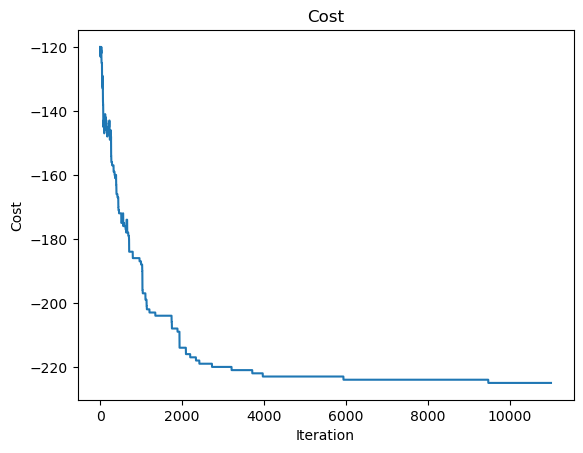

In [49]:
# NOTE - MAY TAKE TIME TO RUN IF NUMBERS ARE LARGE!
KinderAnonym = Kinder_df.Anonym
%time result = anneal(KlassenVektor, Freunde_m, KinderAnonym, temp=1.0, temp_min=0.00001, alpha=0.9, n_iter=100, audit=True)
checkResult(result[0], verbose=True)
print(count_StufeAnzahl(Kinder_df.Anonym, result[0]))
print(count_SexDist(Kinder_df.Anonym, result[0]))
plt.plot([ele[1] for ele in result[2]])
plt.title('Cost')
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.show()

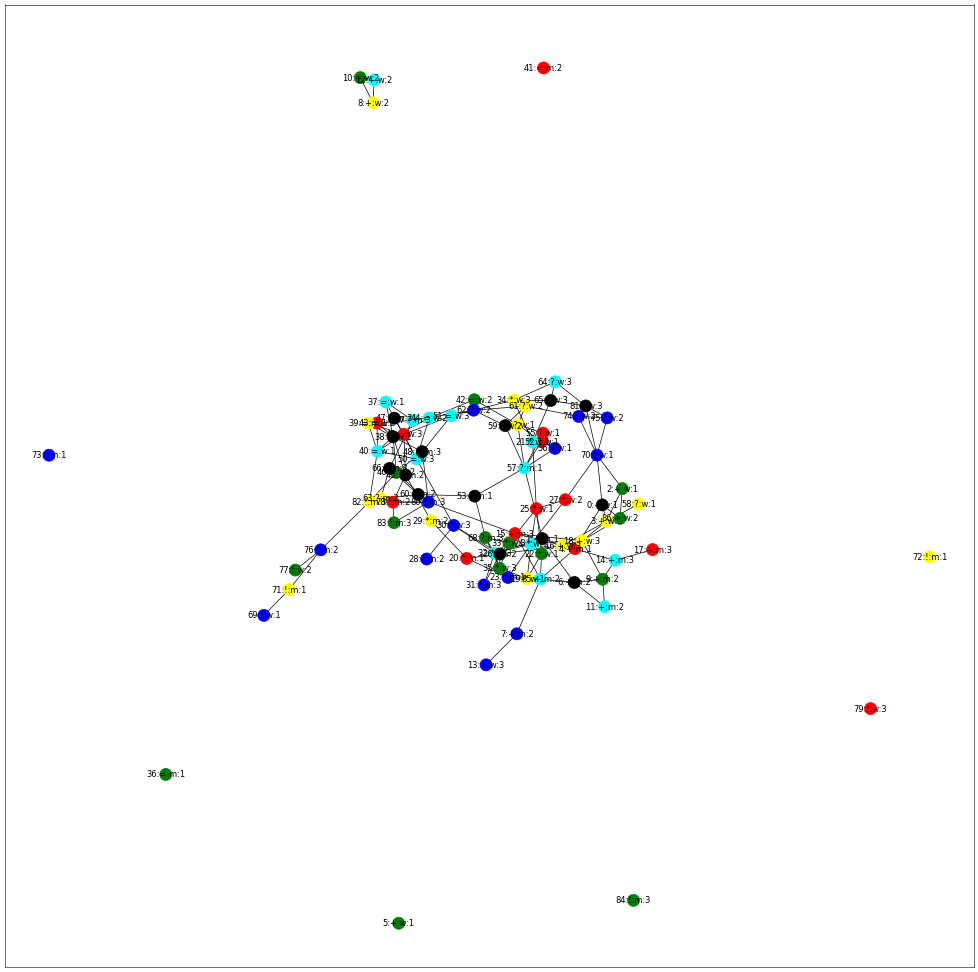

In [50]:
fig = plt.figure(1, figsize=(25, 25), dpi=50)
G = nx.Graph()
G.add_nodes_from(Kinder_df.Anonym)
G.add_edges_from(Freunde_list)
KlassExp = [KlasseNumEncoding[new] for new in result[0]]
color_map = generate_color_map(KlassExp)
nx.draw_networkx(G, with_labels = True, node_color =color_map)

In [51]:
Kinder_df['Klasse'] = [KlasseNumEncoding[new] for new in result[0]]

with pd.ExcelWriter('output.xlsx') as writer:  
    Kinder_df.sort_values(by=['Name', 'Klasse', 'Stufe'], inplace=True)
    Kinder_df.to_excel(writer, sheet_name='Name')
    Kinder_df.sort_values(by=['Klasse', 'Stufe', 'Geschlecht'], inplace=True)
    Kinder_df.to_excel(writer, sheet_name='Klasse')
